In [1]:
from keras.models import Model
from keras.layers import Input,LSTM,Dense,Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [63]:
#some config
batch_size=64
epochs=40
LATENT_DIM=256
num_samples=10000
MAX_NUM_WORDS=20000
EMBEDDING_DIM=100

In [4]:
#where we will store the data
input_text=[] #sentence in original language
target_text=[]#sentence in target language

target_texts_inputs=[] #sentence target language offset by 1 since we are using teacher forcing
 


In [39]:
input_texts=[]
target_texts=[]
target_input_texts=[]
with open(r'F:\mukulml\NLP\spa-eng\spa.txt',encoding='utf-8',errors='ignore') as f:
    lines=f.read()
    lines=lines.strip().split('\n')[:num_samples]
    for line in lines:
        input_text,translation=line.split('\t')[:2]
        target_text=translation + ' <eos>'

        target_input_text='<sos> ' + translation
        
        input_texts.append(input_text)
        target_texts.append(target_text)
        target_input_texts.append(target_input_text)

In [40]:
print('num_samples:',len(input_texts))

num_samples: 10000


In [41]:
#tokenize the inputs
tokenizer=Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(input_texts)
input_sequences=tokenizer.texts_to_sequences(input_texts)

In [46]:
#get the word to index mapping for input language
word2idx_input=tokenizer.word_index
print('found %s number of unique words'% len(word2idx_input))

found 2337 number of unique words


In [47]:
#maximum input length sequence
max_len_input=max(len(s) for s in input_sequences)

In [48]:
max_len_input

5

In [49]:
#tokenize the outputs 
#dont filter the special characters
#otherwise <sos> and <eos> wont appear
tokenizer_o=Tokenizer(num_words=MAX_NUM_WORDS,filters='')
tokenizer_o.fit_on_texts(target_texts+target_input_texts)
target_sequences=tokenizer_o.texts_to_sequences(target_texts)
target_sequences_inputs=tokenizer_o.texts_to_sequences(target_input_texts)

In [50]:
#get the word mapping for output language 
word2idx_outputs=tokenizer_o.word_index
print('found %s unique o/p tokens:'% len(word2idx_outputs))

found 6316 unique o/p tokens:


In [51]:
num_words_output=len(word2idx_outputs)+1

In [54]:
max_len_target=max(len(s) for s in target_sequences)

In [56]:
#pad sequences
encoder_inputs=pad_sequences(input_sequences,maxlen=max_len_input,padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [15  0  0  0  0]


In [57]:
decoder_inputs=pad_sequences(target_sequences_inputs,maxlen=max_len_target,padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)


decoder_inputs[0]: [   2 1468    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


In [58]:
decoder_targets=pad_sequences(target_sequences,maxlen=max_len_target,padding='post')

In [60]:
print('Loading word vectors...')
word2vec = {}
with open(r'F:\mukulml\NLP\spa-eng\glove.6B.100d.txt',encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [66]:
#prepare embedding matrix
num_words=min(MAX_NUM_WORDS,len(word2idx_input)+1)
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx_input.items():
    if i<MAX_NUM_WORDS:
        embedding_vector=word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
        

In [67]:
#create Embedding layer
embedding_layer=Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len_input)

In [69]:
#create targets,since we cannot use sparse categorical crossentropy
#when we have sequences
decoder_target_one_hot=np.zeros((len(input_texts),max_len_target,num_words_output),dtype='float32')

In [70]:
#assign values
for i,d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_target_one_hot[i,t,word]=1
        

In [71]:
decoder_target_one_hot[:1]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [74]:
#building the model
encoder_inputs_placeholder=Input(shape=(max_len_input,))
x=embedding_layer(encoder_inputs_placeholder)
encoder=LSTM(LATENT_DIM,return_state=True)
encoder_outputs,state_h,state_c=encoder(x)

In [76]:
#keep only the states to pass into decoder
encoder_states=[state_h,state_c] #[state_h] for gru

In [77]:
decoder_inputs_placeholder=Input(shape=(max_len_target,))


In [78]:
decoder_embedding=Embedding(num_words_output,LATENT_DIM)
decoder_inputs_x=decoder_embedding(decoder_inputs_placeholder)

In [79]:
#since the decoder is a 'to-many' model we want to have 
#return_sequences = true

decoder_lstm=LSTM(LATENT_DIM,return_sequences=True,return_state=True)

In [80]:
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)


In [81]:
#final dense layer for the prediction
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [85]:
model=Model([encoder_inputs_placeholder,decoder_inputs_placeholder],decoder_outputs)

In [86]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [88]:
r=model.fit([encoder_inputs,decoder_inputs],decoder_target_one_hot,batch_size=128,epochs=10,validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 84s 11ms/step - loss: 3.8370 - acc: 0.5851 - val_loss: 3.0465 - val_acc: 0.5473
Epoch 2/10
8000/8000 [==============================] - 61s 8ms/step - loss: 2.4283 - acc: 0.6623 - val_loss: 2.8727 - val_acc: 0.6254
Epoch 3/10
8000/8000 [==============================] - 60s 8ms/step - loss: 2.2364 - acc: 0.7046 - val_loss: 2.7010 - val_acc: 0.6562
Epoch 4/10
 128/8000 [..............................] - ETA: 2:41 - loss: 2.0580 - acc: 0.7188

C:\Users\HP\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.876886). Check your callbacks.
  % delta_t_median)


8000/8000 [==============================] - 76s 9ms/step - loss: 2.0892 - acc: 0.7131 - val_loss: 2.5838 - val_acc: 0.6594
Epoch 5/10
8000/8000 [==============================] - 60s 8ms/step - loss: 1.9688 - acc: 0.7179 - val_loss: 2.4853 - val_acc: 0.6681
Epoch 6/10
8000/8000 [==============================] - 62s 8ms/step - loss: 1.8622 - acc: 0.7258 - val_loss: 2.3983 - val_acc: 0.6760
Epoch 7/10
8000/8000 [==============================] - 60s 8ms/step - loss: 1.7583 - acc: 0.7355 - val_loss: 2.3331 - val_acc: 0.6838
Epoch 8/10
8000/8000 [==============================] - 58s 7ms/step - loss: 1.6603 - acc: 0.7461 - val_loss: 2.2699 - val_acc: 0.6963
Epoch 9/10
8000/8000 [==============================] - 59s 7ms/step - loss: 1.5707 - acc: 0.7563 - val_loss: 2.2213 - val_acc: 0.7021
Epoch 10/10
8000/8000 [==============================] - 57s 7ms/step - loss: 1.4883 - acc: 0.7644 - val_loss: 2.1795 - val_acc: 0.7087


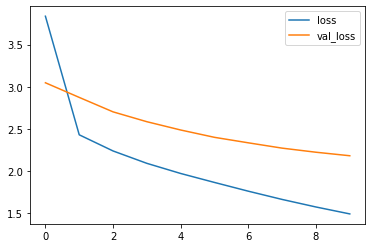

In [91]:
#plot some datab
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [92]:

model.save('s2s.h5')

C:\Users\HP\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_3 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_2/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_2/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [94]:
#make prediction
#the encoder will be stand alone 
#from this we will get our initial decoder_hidden_state

encoder_model=Model(encoder_inputs_placeholder,encoder_states)



In [95]:
decoder_state_input_h=Input(shape=(LATENT_DIM,))
decoder_state_input_c=Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [97]:
decoder_inputs_single=Input(shape=(1,)) #generating one word at a time
decoder_inputs_single_x=decoder_embedding(decoder_inputs_single)


In [98]:
#this time we want to keep the states too, to be output
#by our sampling model
decoder_outputs,h,c=decoder_lstm(decoder_inputs_single_x,initial_state=decoder_states_inputs)

In [99]:
decoder_states=[h,c]

In [100]:
#the sampling model
#inputs=y(t-1),h(t-1),c(t-1)
#outputs=y(t),h(t),c(t)
decoder_model=Model([decoder_inputs_single]+decoder_states_inputs,[decoder_outputs]+decoder_states)

In [102]:
#map index back to real words
#so wecan view the results

idx2word_en={v:k for k,v in word2idx_input.items()}
idx2word_spa={v:k for k,v in word2idx_outputs.items() }

In [104]:
def decode_sequence(input_seq):
    #encode the input as state vectors
    state_value=encoder_model.predict(input_seq)
    #generate empty target sequence of length 1 time step 1
    target_seq=np.zeros((1,1))
#populate the first character of target sequence with start ch.
    target_seq[0,0]=word2idx_outputs['<sos>']
    
    #if we get this we break
    eos = word2idx_outputs['<eos>']
    
    #create translation
    output_sentence=[]
    for _ in range(max_len_target):
        output_tokens,h,c=decoder_model.predict([target_seq]+state_value)
        
        #get next word
        idx=np.argmax(output_tokens[0,0,:])
        
        if eos==idx:
            break
        
        word=''
        if idx>0:
            word=idx2word_spa[idx]
            output_sentence.append(word)
            
            #update the decoder input
            #which is just the word generated
            
            target_seq[0,0]=idx
            
            #update states
            state_value=[h,c]
            
        return ' '.join(output_sentence)
    

In [107]:
while True:
    #do some translations
    i=np.random.choice(len(input_texts))
    
    input_seq=encoder_inputs[i:i+1]
    translation=decode_sequence(input_seq)
    print('-')
    print('Input:',input_texts[i])
    print('translation:',translation)
    
    ans=input('continue? [y/n]')
    if ans and ans.lower().startswith('n'):
        break
    


-
Input: I was an idiot.
translation: él.
continue? [y/n]y
-
Input: Tom is in shock.
translation: ¡no
continue? [y/n]n
